In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, KFold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

sns.set_theme(style='whitegrid')
np.random.seed(3)

In [12]:
# Make data
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

# we turn our (100, 100)-arrays into (10000,)-arrays
x = x.ravel()
y = y.ravel()


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

k = 0.1 # noise coefficient
z = FrankeFunction(x,y) # + k*np.random.randn(n**2) # target variable with standard normal noise

### Learning Curve

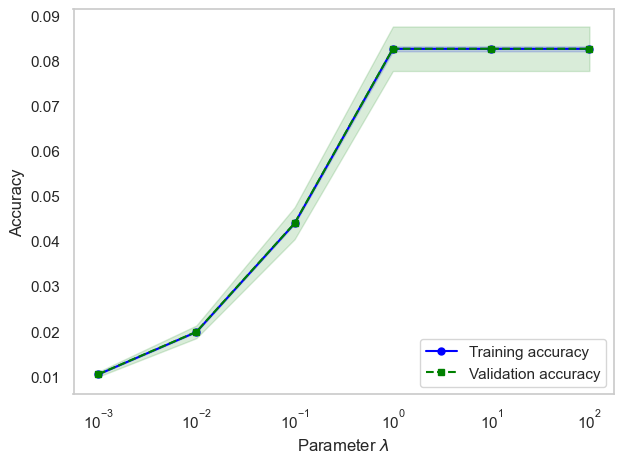

In [69]:
X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

pipeline = make_pipeline(
                    PolynomialFeatures(degree=3),
                    StandardScaler(),
                    Lasso(max_iter=10000))

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=z_train, 
                param_name='lasso__alpha', 
                param_range=param_range,
                cv=10,
                scoring='neg_mean_squared_error')

train_mean = np.mean(np.abs(train_scores), axis=1)
train_std = np.std(np.abs(train_scores), axis=1)
test_mean = np.mean(np.abs(test_scores), axis=1)
test_std = np.std(np.abs(test_scores), axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel(r'Parameter $\lambda$')
plt.ylabel('Accuracy')
#plt.ylim([-0.1, 0.1])
plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

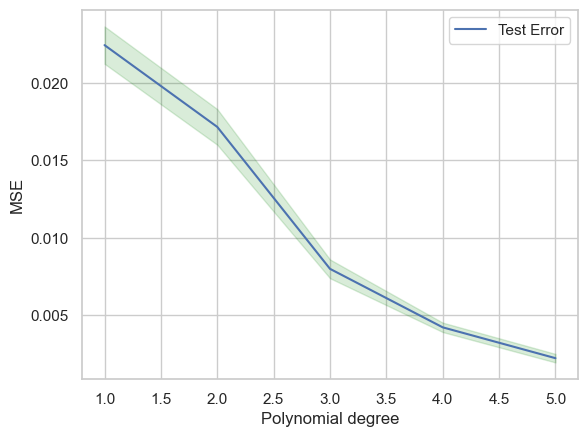

In [53]:
X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

Maxpolydegree = 5
estimated_mse_sklearn = np.zeros(Maxpolydegree)
estimated_mse_std = np.zeros(Maxpolydegree)
polynomial = np.zeros(Maxpolydegree)
k = 5
kfold = KFold(n_splits = k)

for polydegree in range(0, Maxpolydegree):
    polynomial[polydegree] = polydegree+1
    pipe_lr = make_pipeline(PolynomialFeatures(degree=polydegree+1),
                            StandardScaler(),
                            LinearRegression())
# loop over trials in order to estimate the expectation value of the MSE
    estimated_mse_folds = cross_val_score(pipe_lr, X_test, z_test, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[polydegree] = np.mean(-estimated_mse_folds)

    estimated_mse_std[polydegree] = np.std(estimated_mse_folds)   

plt.fill_between(polynomial, 
                 estimated_mse_sklearn + estimated_mse_std,
                 estimated_mse_sklearn - estimated_mse_std,
                 alpha=0.15, color='green')

plt.plot(polynomial, estimated_mse_sklearn, label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Ridge

Used code from github

4 1.0 0.023601556650500975
[0.02360156 0.02360156 0.02360156 0.02360156 0.02360156 0.02360165]


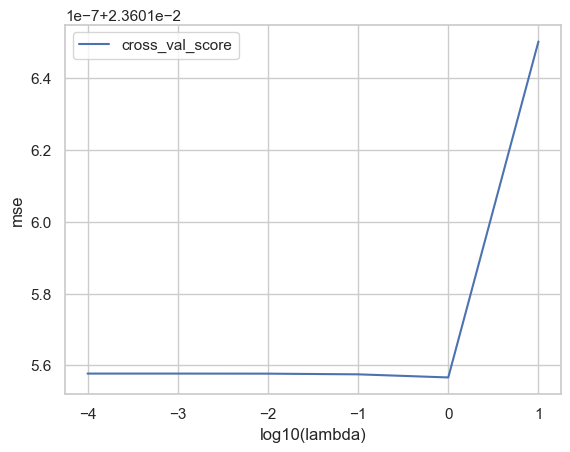

4 1.0 0.01704269592136868
[0.01704271 0.01704271 0.01704271 0.0170427  0.0170427  0.0170488 ]


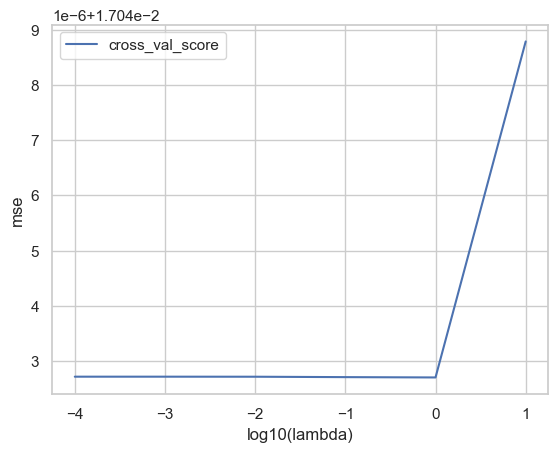

1 0.001 0.0077875036580609775
[0.0077875  0.0077875  0.00778751 0.00778839 0.00786263 0.00979584]


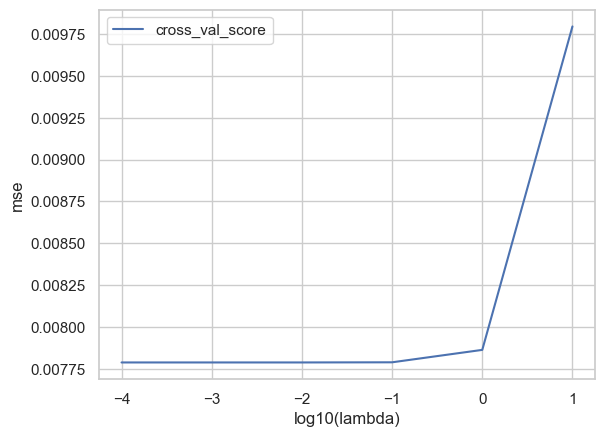

0 0.0001 0.004076706699582452
[0.00407671 0.00407672 0.00408188 0.00439579 0.00683489 0.00875564]


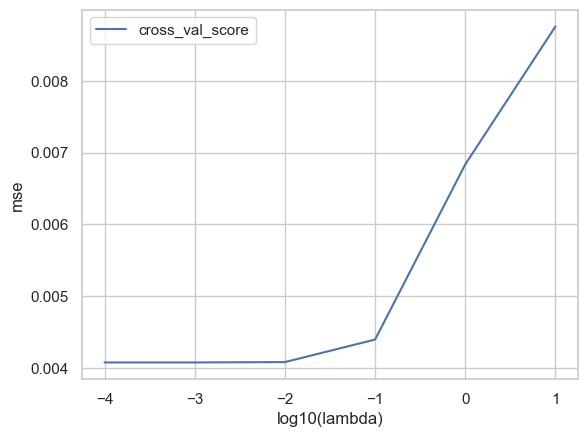

0 0.0001 0.0020757628992639997
[0.00207576 0.0020807  0.00226905 0.00326415 0.00526836 0.00849183]


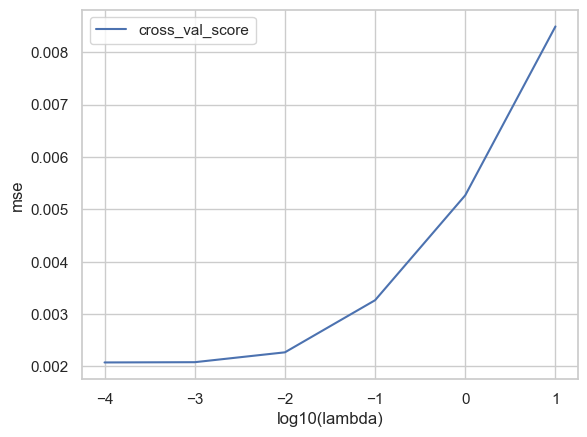

In [27]:
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

logmin, logmax, m = -4, 1, 6 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

estimated_mse_sklearn = np.zeros(m)

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

degrees = list(range(1,6))
for deg in degrees:
    for idx, lmb in enumerate(llambdas):
        pipeline = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler()
            )
        
        model = Ridge(alpha = lmb)

        X = pipeline.fit_transform(X_train)
        estimated_mse_folds = cross_val_score(model, X, z_train, scoring='neg_mean_squared_error', cv=10)

        # cross_val_score return an array containing the estimated negative mse for every fold.
        # we have to the the mean of every array in order to get an estimate of the mse of the model
        estimated_mse_sklearn[idx] = np.mean(abs(estimated_mse_folds))

    min_mse = np.argmin(estimated_mse_sklearn)
    print(min_mse, llambdas[min_mse], estimated_mse_sklearn[min_mse])

    ## Plot and compare the slightly different ways to perform cross-validation

    plt.figure()

    plt.plot(np.log10(llambdas), estimated_mse_sklearn, label = 'cross_val_score')

    plt.xlabel('log10(lambda)')
    plt.ylabel('mse')

    plt.legend()

    plt.show()

### Lasso

0 0.0001 0.02360157709516216


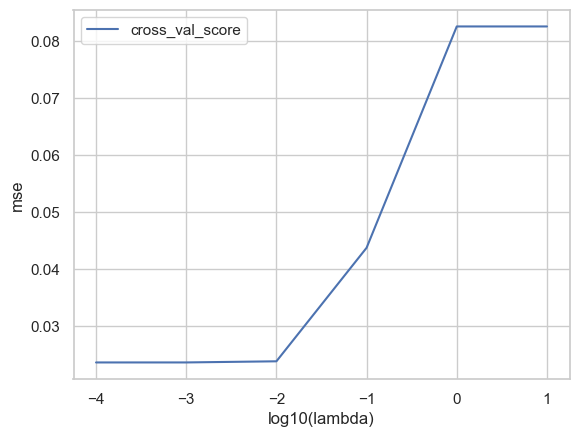

0 0.0001 0.01704360259958878


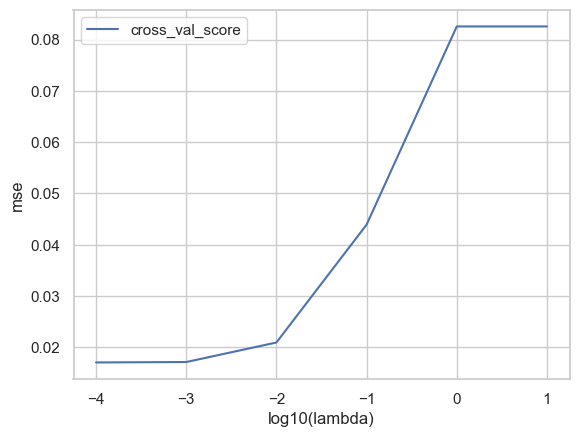

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+01, tolerance: 5.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+01, tolerance: 5.944e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

0 0.0001 0.00792069725777951


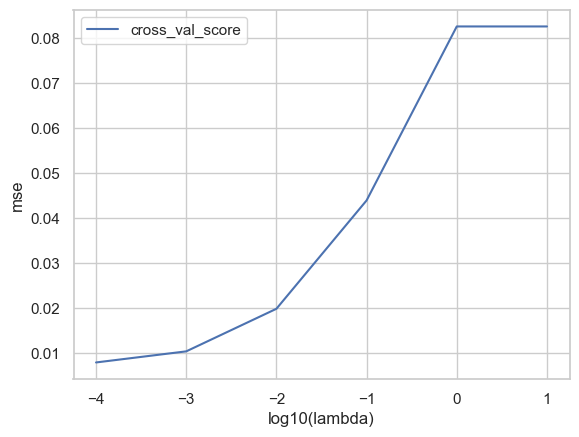

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+01, tolerance: 5.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+01, tolerance: 5.944e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

0 0.0001 0.008053348117967244


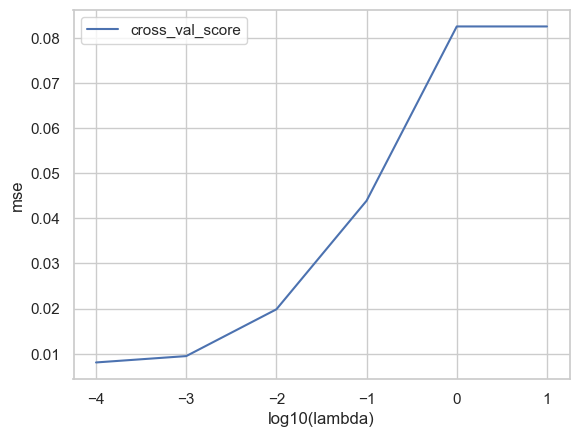

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+01, tolerance: 5.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e+01, tolerance: 5.944e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

0 0.0001 0.007538989580701648


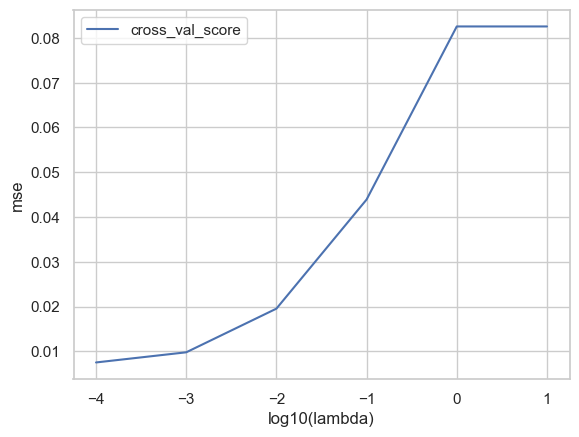

In [30]:
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

logmin, logmax, m = -4, 1, 6 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

estimated_mse_sklearn = np.zeros(m)

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

degrees = list(range(1,6))
for deg in degrees:
    for idx, lmb in enumerate(llambdas):
        pipeline = make_pipeline(
            PolynomialFeatures(degree=deg),
            StandardScaler()
            )
        
        model = Lasso(alpha = lmb)

        X = pipeline.fit_transform(X_train)
        estimated_mse_folds = cross_val_score(model, X, z_train, scoring='neg_mean_squared_error', cv=10)

        # cross_val_score return an array containing the estimated negative mse for every fold.
        # we have to the the mean of every array in order to get an estimate of the mse of the model
        estimated_mse_sklearn[idx] = np.mean(abs(estimated_mse_folds))

    min_mse = np.argmin(estimated_mse_sklearn)
    print(min_mse, llambdas[min_mse], estimated_mse_sklearn[min_mse])

    ## Plot and compare the slightly different ways to perform cross-validation

    plt.figure()

    plt.plot(np.log10(llambdas), estimated_mse_sklearn, label = 'cross_val_score')

    plt.xlabel('log10(lambda)')
    plt.ylabel('mse')

    plt.legend()

    plt.show()

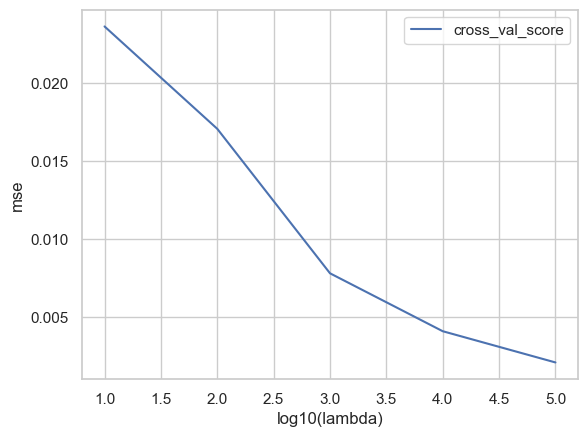

In [35]:
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

estimated_mse_sklearn = np.zeros(5)

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

degrees = list(range(1,6))
for deg in degrees:
    pipeline = make_pipeline(
        PolynomialFeatures(degree=deg),
        StandardScaler()
        )
        
    model = LinearRegression()

    X = pipeline.fit_transform(X_train)
    estimated_mse_folds = cross_val_score(model, X, z_train, scoring='neg_mean_squared_error', cv=10)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[deg-1] = np.mean(abs(estimated_mse_folds))

    min_mse = np.argmin(estimated_mse_sklearn)

    ## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(degrees, estimated_mse_sklearn, label = 'cross_val_score')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

### OLS

4 1.0 0.0020757661387392308


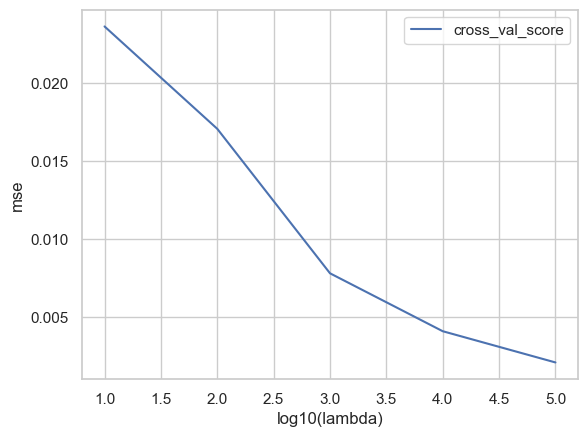

In [37]:
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

degrees = list(range(1,6))

estimated_mse_sklearn = np.zeros(len(degrees))

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

for deg in degrees:
    pipeline = make_pipeline(
        PolynomialFeatures(degree=deg),
        StandardScaler()
        )
        
    model = LinearRegression()

    X = pipeline.fit_transform(X_train)
    estimated_mse_folds = cross_val_score(model, X, z_train, scoring='neg_mean_squared_error', cv=10)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[deg-1] = np.mean(abs(estimated_mse_folds))

min_mse = np.argmin(estimated_mse_sklearn)
print(min_mse, llambdas[min_mse], estimated_mse_sklearn[min_mse])

## Plot and compare the slightly different ways to perform cross-validation
plt.figure()

plt.plot(degrees, estimated_mse_sklearn, label = 'cross_val_score')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

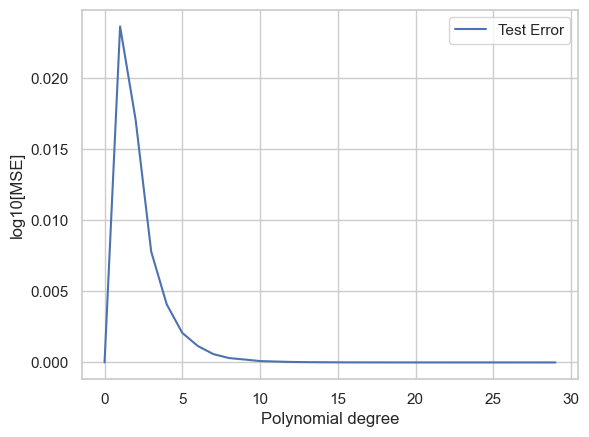

In [54]:
Maxpolydegree = 30
estimated_mse_sklearn = np.zeros(Maxpolydegree)
polynomial = np.zeros(Maxpolydegree)
k = 5
kfold = KFold(n_splits = k)

degrees = list(range(1,6))

X = np.column_stack((x,y))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

for polydegree in range(1, Maxpolydegree):
    pipeline = make_pipeline(
        PolynomialFeatures(degree=polydegree),
        StandardScaler()
        )
                
    model = LinearRegression()

    X = pipeline.fit_transform(X_train)
    polynomial[polydegree] = polydegree
    estimated_mse_folds = cross_val_score(LinearRegression(), X, z_train, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[polydegree] = np.mean(-estimated_mse_folds)

plt.plot(polynomial, estimated_mse_sklearn, label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()